In [2]:
import keras
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization

In [3]:
data = pd.read_csv('data/label.csv')

In [4]:
data.head()

,hour,minute
0,4,2
1,9,44
2,3,6
3,3,30
4,2,3


In [19]:
def preprocess(im):
    
    im = im/255
    im -= .5
    return im

In [16]:
channel = 1
im_size = 100
path = 'data/images/'

In [8]:
def load_image_batch(ids, batch_size=32):
    
    image_batch = np.zeros((batch_size, im_size, im_size, channel))
    
    label_hour = np.zeros((batch_size, 1))
    label_min = np.zeros((batch_size, 1))
    batch_ids = np.random.choice(ids, batch_size)
    
    ind = 0
    for i in range(len(batch_ids)):
        
        if channel == 1:
            im = Image.open(path + str(batch_ids[i]) + '.jpg').convert('L')
        else:
            im = Image.open(path + str(batch_ids[i]) + '.jpg')
        im = im.resize((im_size,im_size), Image.ANTIALIAS)
        im = np.array(im)
        image_batch[ind] = preprocess(im).reshape((im_size, im_size, channel))
        label_hour[ind] = (data['hour'][data.index==batch_ids[i]])
        label_min[ind] = (data['minute'][data.index==batch_ids[i]])/60
        ind += 1
            
    return (np.array(image_batch), np.array(label_hour), np.array(label_min))

In [113]:
inp = Input(shape=(im_size,im_size, channel))

x = Conv2D(50, kernel_size=5, strides=2, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = BatchNormalization()(x)

x = Conv2D(100, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(150, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(200, kernel_size=3, strides=1, activation='relu')(x)
x = Dropout(.4)(x)

x = Flatten()(x)

hour = Dense(144, activation='relu')(x)
hour = Dense(144, activation='relu')(hour)
hour = Dense(12, activation='softmax', name='hour')(hour)

minute = Dense(100, activation='relu')(x)
minute = Dense(200, activation='relu')(minute)
minute = Dense(1, activation='linear', name='minute')(minute)

model = Model(inputs=inp, outputs=[hour, minute])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 48, 48, 50)   1300        input_37[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_84 (MaxPooling2D) (None, 24, 24, 50)   0           conv2d_148[0][0]                 
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 24, 24, 50)   200         max_pooling2d_84[0][0]           
__________________________________________________________________________________________________
conv2d_149

In [15]:
train_ids = np.arange(40000)
test_ids = np.arange(10000) + 40000

x_train, y1_train, y2_train = load_image_batch(train_ids, 40000)

x_test, y1_test, y2_test = load_image_batch(test_ids, 500)

In [122]:
adam = keras.optimizers.adam(lr=.00001)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=adam, metrics=['accuracy', 'mae'])

In [127]:
model.fit(x_train, [y1_train, y2_train], epochs=1, batch_size=256, validation_data=(x_test, [y1_test, y2_test]))

Train on 40000 samples, validate on 100 samples
Epoch 1/1
40000/40000 [==============================] - 15s 376us/step - loss: 0.0112 - hour_loss: 0.0025 - minute_loss: 0.0086 - hour_acc: 0.9994 - hour_mean_absolute_error: 5.4811 - minute_acc: 0.0160 - minute_mean_absolute_error: 0.0683 - val_loss: 0.0577 - val_hour_loss: 0.0480 - val_minute_loss: 0.0097 - val_hour_acc: 0.9900 - val_hour_mean_absolute_error: 5.1767 - val_minute_acc: 0.0300 - val_minute_mean_absolute_error: 0.0691


## Testing

In [6]:
model = keras.models.load_model('clock.model')

In [14]:
def predict(ind):
                    
    im = Image.open(path + str(ind) + '.jpg')
    plt.imshow(im)
    print('Input image:')
    plt.show()
    im = im.convert('L')
    im = im.resize((im_size,im_size), Image.ANTIALIAS)
    im = np.array(im)
    im = preprocess(im).reshape((1, im_size, im_size, channel))

    time = model.predict(im)
    
    hour = np.argmax(time[0])
    minute = int(time[1][0][0]*60)
    print('Detected Time:', str(hour)+':'+str(minute))

Input image:


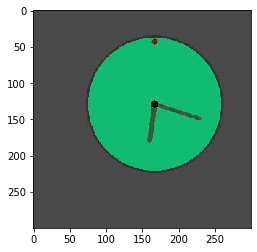

Detected Time: 6:19


In [20]:
predict(test_ids[42])